# NEW Preprocessing pipeline 

Updated: 03/05/2022

## Outline

<img src="../static/preprocessing_pipeline_diagram.svg">

1. __Temporal filtering__

High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter 
using mne-Python [1]. 

2. __Segmenting the data__

Epochs are non-overlapping data segments created from the continuous data with a 
given duration.
Epochs can be created from (1) events; there is a custom method that created epochs 
based on annotations in the raw data, (2) without events, data segments are created 
from the beginning of the raw data. 

3. __Outlier data rejection__  

- _Preliminar rejection_

Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch 
variance and amplitude range.

- _ICA decomposition_  

The default method is the infomax algorithm, however it can be changed in the 
configuration file along with the number of components and the decimation parameter. 
Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on 
their topographies, time-courses or frequency spectra.

- _Autoreject_  

Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for 
the epochs. In order to reduce computation time that increases with the number of 
segments and channels, autoreject can be fitted on a representative subset of epochs 
(25% of total epochs). Once the parameters are learned, the solution can be applied to 
any data that contains channels that were used during fit.

4. __Outlier channel interpolation__

The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good 
channels to make predictions of each channel in small non-overlapping 4 seconds long 
time windows. It uses a method of spherical splines (Perrin et al., 1989) to 
interpolate the bad sensors.


#### References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for faster but static plots

In [1]:
import os
from pathlib import Path

from ipyfilechooser import FileChooser
import pandas as pd

from meeg_tools.preprocessing import *
from meeg_tools.utils.epochs import create_epochs_from_events, create_metadata
from meeg_tools.utils.raw import read_raw_measurement, filter_raw, concat_raws_with_suffix
from meeg_tools.utils.log import update_log

%matplotlib qt

# Load raw data

See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  


If you have an error message with "Unsupported file type ['.vhdr']", then it means the file has been incorrectly renamed after creation. You have to rename the file correctly by directly editing the header (.vhdr) file and read it again.

In [2]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
base_path = 'C:/Users/teodora.vekony/BML-MEMO LAB Dropbox/bml memo members/Teodora_Vekony/GitHub_Projects/eeg-workshop'
fc = FileChooser(base_path)
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='C:\Users\teodora.vekony\BML-MEMO LAB Dropbox\bml memo members\Teodora_Vekony\GitHub_Projects…

In [3]:
# Load selected file (when the data was recorded in one piece i.e. there is only one recording in the folder)
raw = read_raw_measurement(raw_file_path=fc.selected)

Extracting parameters from C:\Users\teodora.vekony\BML-MEMO LAB Dropbox\bml memo members\Teodora_Vekony\GitHub_Projects\eeg-workshop\data\1_S_Day1.vhdr...
Setting channel info structure...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2020-09-07 10:00:23 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 1_S_Day1
>


## Concatenate raw data

We can use this function when there was an issue with the recording and there are multiple EEG recordings for one measurement.


In [4]:
# note that we choose a folder and NOT a file name as before
#raws_folder_path = 'C:/Users/teodora.vekony/BML-MEMO LAB Dropbox/bml memo members/Teodora_Vekony/GitHub_Projects/eeg-workshop/data/196_S/Day1/EEG/'

# with the suffix argument we specify what kind of files to look for
#raw = concat_raws_with_suffix(path_to_raw_files=raws_folder_path, suffix='.vhdr')

## Select condition

The current logic for saving the preprocessed files is to create subfolders inside `base_path`,
with the name "preprocessed" and the name of the condition (e.g. "epochs_asrt", "epochs_rs").

Always double-check that the condition name (e.g. epochs_asrt) and file path are correct!

In [5]:
condition = 'epochs_asrt_new'

# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
epochs_path = os.path.join(base_path, folder_name, condition)


# Create path to epoch files
if not os.path.exists(epochs_path):
    os.makedirs(epochs_path)
    
print(epochs_path)

C:/Users/teodora.vekony/BML-MEMO LAB Dropbox/bml memo members/Teodora_Vekony/GitHub_Projects/eeg-workshop\preprocessed\epochs_asrt_new


## Temporal filtering

We apply a bandpass filter on the continuous data using the `filter_raw` function.

The default parameters can be checked with `settings['bandpass_filter']`

In [6]:
raw_bandpass = filter_raw(raw=raw)

Reading 0 ... 3162589  =      0.000 ...  6325.178 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:    9.4s finished


## Create epochs

### A. Create epochs for event-related analysis

We create epochs from __selected__ events (stimuli) in the data.

Epochs are created with respect to the stimulus onset defined by `start_time` and 
`end_time` within `settings['epochs']`.

In [7]:
#longer version
settings['epochs']['start_time'] = -0.700 # 700 ms before stimulus onset
settings['epochs']['end_time'] = 0.75 # 750 ms after stimulus onset

In [8]:
settings['epochs']

{'start_time': -0.7, 'end_time': 0.75, 'duration': 1}

In [9]:
events_ids = np.concatenate([np.arange(10, 82, 1), 
                             np.arange(10, 82, 1) + 100,
                            [210, 211, 212, 213, 214, 215, 216]]) # boundaries of epochs

print(events_ids)

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 210 211 212 213 214 215 216]


In [10]:
epochs = create_epochs_from_events(raw=raw_bandpass, event_ids=events_ids)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 38', 'Stimulus/S 39', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 64', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 67', 'Stimulus/S 68', 'Stimulus/S 69', 'Stimulus/S 70', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 75', 'Stimulus/S 76', 'Stimulus/S 77', 

## Create metadata for epochs (optional)

- adding metadata makes it easier to select epochs of different types
- custom triggers are selected from the raw instance

- metadata can be added or replaced later (e.g. after preprocessing)

In [11]:
metadata = create_metadata(epochs=epochs)

# We have to assign it to the epochs instance to take effect
epochs.metadata = metadata

Found these indices for these epoch boundary events: 
210	812
211	2167
212	3550
213	4930
214	6339
215	7741
Adding metadata with 11 columns


In [12]:
# subselecting epochs 
# Here we could also include thrills, repetitions, or practice stimuli.
# ICA should not run on duplicate data (epochs should not be overlapping!)

#Now we select here ALL arrow trials, including incorrect responses, trills, repetitions etc...

epochs = epochs["triplet == 'low' | triplet == 'high' | triplet == 'trill' | triplet == 'repetition' | triplet == 'X' | triplet == 'practice'"]

In [13]:
epochs.metadata

,time_in_samples,stim,id,epoch,answer,arrow,triplet,triplet_type,sequence,stimuli,rewiring
3,244003,0,62,0.0,correct,left,practice,NaN,NaN,NaN,NaN
6,244762,0,62,0.0,correct,up,practice,NaN,NaN,NaN,NaN
9,245521,0,62,0.0,correct,down,practice,NaN,NaN,NaN,NaN
12,246280,0,62,0.0,incorrect,left,practice,NaN,NaN,NaN,NaN
17,247056,0,62,0.0,correct,up,practice,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7722,2979765,0,11,5.0,correct,right,high,pattern,A,pattern,high-low
7725,2980524,0,14,5.0,correct,up,high,high-random,A,random,high-high
7728,2981283,0,11,5.0,correct,left,high,pattern,A,pattern,high-low
7731,2982042,0,16,5.0,incorrect,right,low,low-random,A,random,low-low


In [14]:
# We can check here whether we have all 6 periods - 5 epochs + practice Day 1 OR 6 epochs Day 2
assert len(epochs.metadata['epoch'].unique()) == 6

In [15]:
# We can check here whether we have all 85/block trials in each epoch

if (len(epochs["epoch == 0"].metadata) > 0):
    if (epochs["epoch == 0"].metadata.shape[0] % 85) == 0:
        print("I found all trials in Practice Epoch")
    else:
        raise TypeError("Missing trials in Practice Epoch") 
    
if (epochs["epoch == 1"].metadata.shape[0] % 85) == 0:
    print("I found all trials in Epoch 1")
else:
    raise TypeError("Missing trials in Epoch 1")
    
if (epochs["epoch == 2"].metadata.shape[0] % 85) == 0:
    print("I found all trials in Epoch 2")
else:
    raise TypeError("Missing trials in Epoch 2")
    
if (epochs["epoch == 3"].metadata.shape[0] % 85) == 0:
    print("I found all trials in Epoch 3")
else:
    raise TypeError("Missing trials in Epoch 3")
    
if (epochs["epoch == 4"].metadata.shape[0] % 85) == 0:
    print("I found all trials in Epoch 4")
else:
    raise TypeError("Missing trials in Epoch 4")
        
if (epochs["epoch == 5"].metadata.shape[0] % 85) == 0:
       print("I found all trials in Epoch 5")
else:
    raise TypeError("Missing trials in Epoch 5")
    
    
if (len(epochs["epoch == 6"].metadata) > 0):
    if (epochs["epoch == 6"].metadata.shape[0] % 85) == 0:
        print("I found all trials in Epoch 6")
    else:
        raise TypeError("Missing trials in Epoch 6")

I found all trials in Practice Epoch
I found all trials in Epoch 1
I found all trials in Epoch 2
I found all trials in Epoch 3
I found all trials in Epoch 4
I found all trials in Epoch 5


In [16]:
trial_numbers_block = np.arange(1, 86)
epochs.metadata['trial_number_block'] = np.resize(trial_numbers_block, epochs.metadata.shape[0])

trial_numbers_task = np.arange(1, len(epochs.metadata)+1)
epochs.metadata['trial_number_task'] = np.resize(trial_numbers_task, epochs.metadata.shape[0])

In [17]:
epochs.metadata

,time_in_samples,stim,id,epoch,answer,arrow,triplet,triplet_type,sequence,stimuli,rewiring,trial_number_block,trial_number_task
3,244003,0,62,0.0,correct,left,practice,NaN,NaN,NaN,NaN,1,1
6,244762,0,62,0.0,correct,up,practice,NaN,NaN,NaN,NaN,2,2
9,245521,0,62,0.0,correct,down,practice,NaN,NaN,NaN,NaN,3,3
12,246280,0,62,0.0,incorrect,left,practice,NaN,NaN,NaN,NaN,4,4
17,247056,0,62,0.0,correct,up,practice,NaN,NaN,NaN,NaN,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7722,2979765,0,11,5.0,correct,right,high,pattern,A,pattern,high-low,81,2376
7725,2980524,0,14,5.0,correct,up,high,high-random,A,random,high-high,82,2377
7728,2981283,0,11,5.0,correct,left,high,pattern,A,pattern,high-low,83,2378
7731,2982042,0,16,5.0,incorrect,right,low,low-random,A,random,low-low,84,2379


## Run preprocessing


### 1.1. Preliminary epoch rejection

In [18]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Using data from preloaded Raw for 2380 events and 726 original time points ...
0 bad epochs dropped
Bad epochs by amplitude
	[  74  118  119  148  204  330  483  484  535  920 1105 1106 1312 1323
 1418 1567 1687 1690 1719 1832 1928 2040 2143 2149 2267 2268 2326 2327
 2346]
Bad epochs by deviation
	[  34   35  201  204  205  245  359  368  369  383  435  517  535  595
  659  660  696  848  861  919  920  930  931 1008 1009 1105 1312 1401
 1402 1411 1419 1538 1586 1587 1663 1670 1671 1686 1690 1815 1927 1928
 2017 2018 2208 2209 2267 2268 2269 2295]
Bad epochs by variance
	[ 118  119  204  483  484  535  920 1105 1302 1305 1311 1312 1313 1670
 1685 1686 1689 1690 1713 1719 1815 1816 1893 1949 1951 2017 2018 2040
 2143 2256 2257 2258 2259 2261 2267 2268 2270 2295 2326 2327 2328 2329
 2337 2338 2346 2347 2349 2377 2378]
Dropped 95 epochs: 34, 35, 74, 118, 119, 148, 201, 204, 205, 245, 330, 359, 368, 369, 383, 435, 483, 484, 517, 535, 595, 659, 660, 696, 848, 8

### 1.2. Run ICA


When visualizing the components, it is recommended to subset the data (see below).


Picard can be used to solve the same problems as FastICA, Infomax, and extended Infomax, but typically converges faster than either of those methods. To make use of Picard’s speed while still obtaining the same solution as with other algorithms, you need to specify method='picard' and fit_params as a dictionary with the following combination of keys:

dict(ortho=False, extended=False) for Infomax  

dict(ortho=False, extended=True) for extended Infomax  

dict(ortho=True, extended=True) for FastICA


In [19]:
settings["ica"]

{'n_components': 32, 'method': 'picard', 'decim': None}

In [20]:
ica = run_ica(epochs_faster, fit_params=dict(ortho=False, extended=True))

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Using data from preloaded Raw for 2285 events and 726 original time points ...
Selecting by number: 32 components
Using data from preloaded Raw for 2285 events and 726 original time points ...
Fitting ICA took 314.4s.
EOG channels are not found. Attempting to use Fp1,Fp2 channels as EOG channels.
Using EOG channels: Fp1, Fp2
Using data from preloaded Raw for 2285 events and 726 original time points ...
Using data from preloaded Raw for 2285 events and 726 original time points ...
Using data from preloaded Raw for 2285 events and 726 original time points ...
Using data from preloaded Raw for 2285 events and 726 original time points ...


Using data from preloaded Raw for 232 events and 726 original time points ...
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Using matplotlib as 2D backend.
Opening ica-browser...


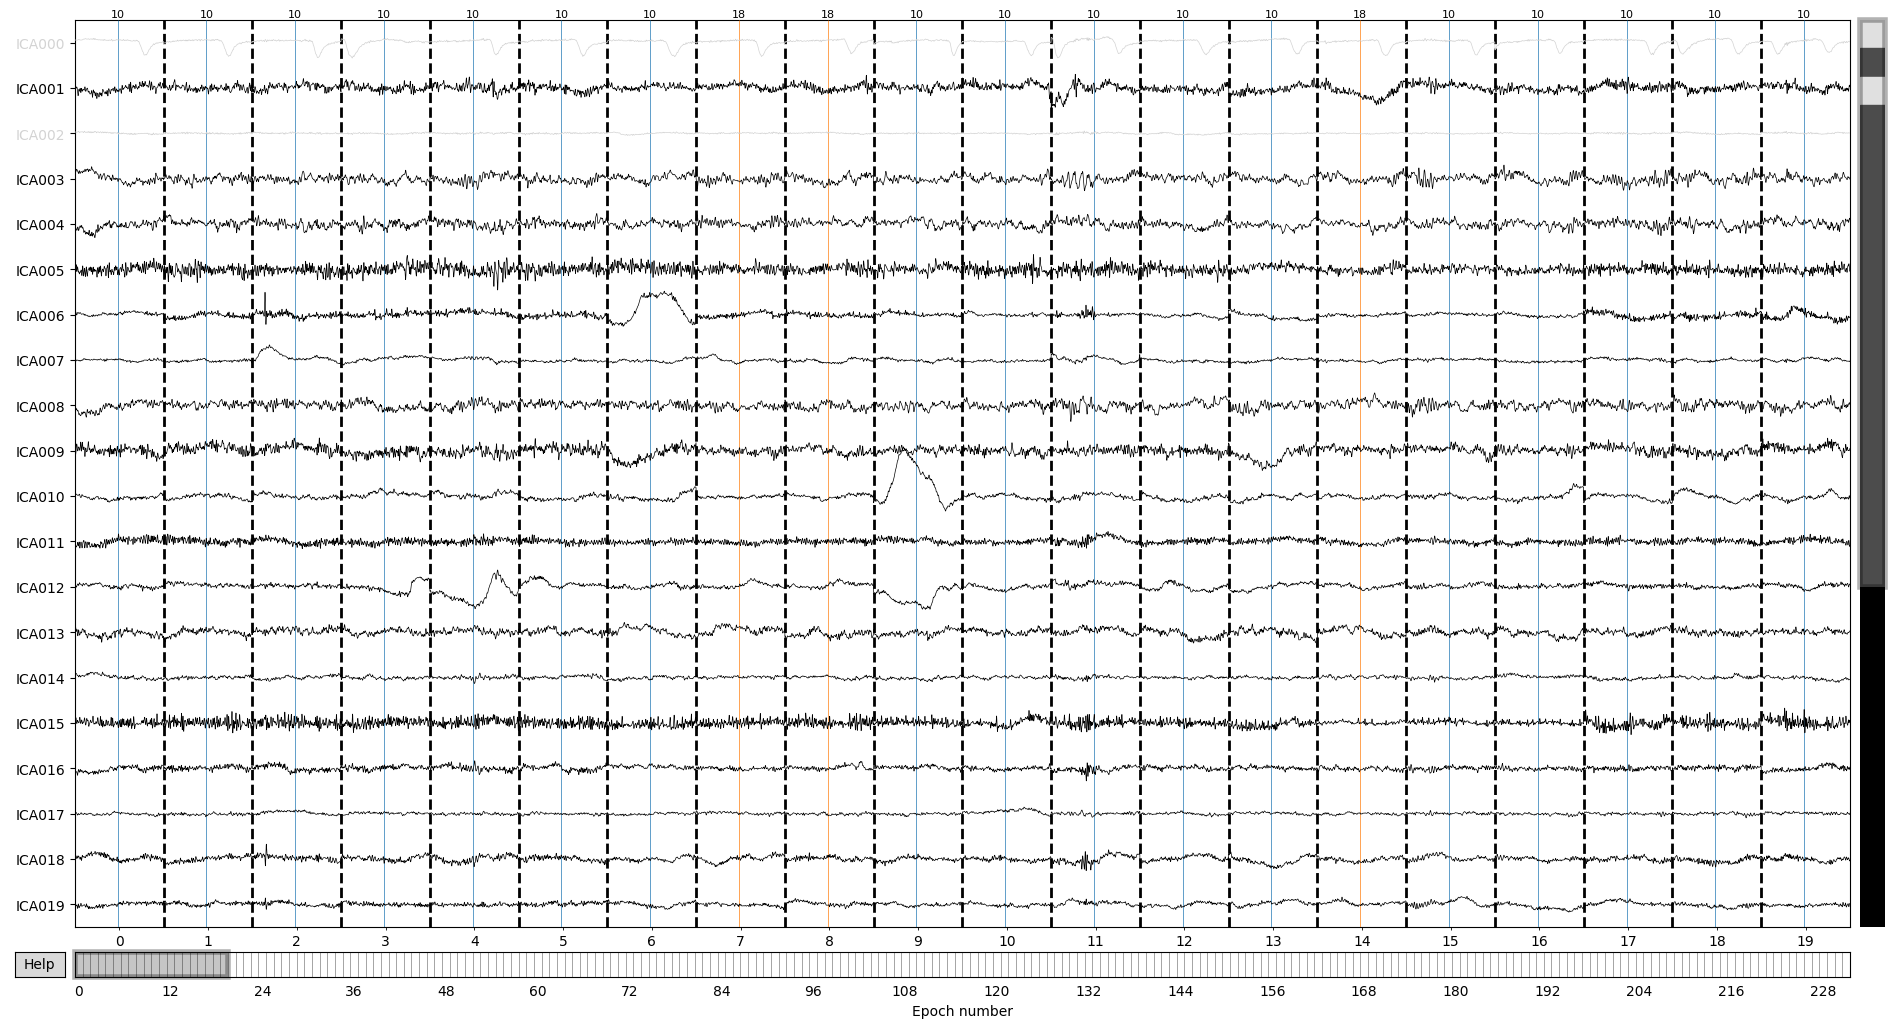

In [21]:
# Visualize components on epochs
# Subset epochs to reduce execution time (e.g. take epochs from every 7th event)
subset = list(epochs.event_id.keys())[::7]
# Exclude components by selecting them, right click on component name to visualize source:
ica.plot_sources(epochs_faster[subset])

In [22]:
# Plot component topographies
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x731 with 12 Axes>]

In [23]:
ica.exclude

[0, 2]

In [24]:
# After selecting the components to exclude, apply ICA to epochs
epochs_ica = apply_ica(epochs_faster, ica)

Using data from preloaded Raw for 2285 events and 726 original time points ...
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


In [25]:
print(epochs_ica.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 2
 dig: 64 items (64 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2020-09-07 10:00:23 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 1_S_Day1_ICA
>


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 


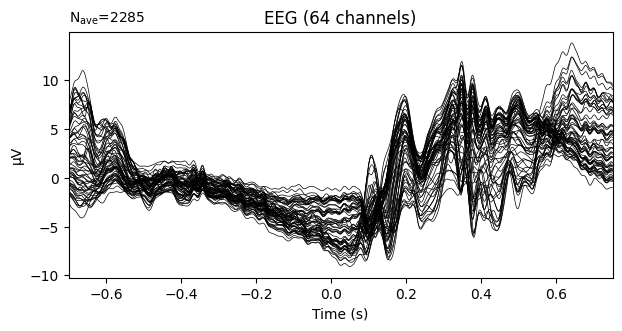

In [26]:
epochs_ica.average().plot()

### 1.4. Save cleaned epochs (recommended)

In [27]:
os.path.join(epochs_path, f'{epochs_ica.info["temp"]}-epo.fif.gz')

'C:/Users/teodora.vekony/BML-MEMO LAB Dropbox/bml memo members/Teodora_Vekony/GitHub_Projects/eeg-workshop\\preprocessed\\epochs_asrt_new\\1_S_Day1_ICA-epo.fif.gz'

In [28]:
# Save ICA cleaned epochs 
epochs_ica.save(os.path.join(epochs_path, f'{epochs_ica.info["temp"]}-epo.fif.gz'),
                overwrite=True)

# Save ICA solution to file
# File path will be .../.../preprocessed/epochs_asrt/ica
ica_path = os.path.join(epochs_path, "ica")
if not os.path.exists(ica_path):
    os.makedirs(ica_path)

ica.save(os.path.join(ica_path, f'{epochs_ica.info["temp"]}-ica.fif.gz'))

Writing ICA solution to C:\Users\teodora.vekony\BML-MEMO LAB Dropbox\bml memo members\Teodora_Vekony\GitHub_Projects\eeg-workshop\preprocessed\epochs_asrt_new\ica\1_S_Day1_ICA-ica.fif.gz...


Method,picard
Fit,69 iterations on epochs (1658910 samples)
ICA components,32
Explained variance,99.3 %
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,ICA000ICA002


### 1.5. Create a log file 

We can create a log file for the preprocessed data and store metadata
that could be useful to remember. You can add more columns to this, or 
remove the ones that are not needed. For documentation purporses, it is 
recommended to store the number of rejected and total epochs, the number of
ICA components that were rejected, the number of interpolated electrodes etc.
You can also add a column with "notes" to add custom descriptions about the data.

In [29]:
# Change the author to your name
settings["log"]["author"] = "Teodora Vekony"

In [30]:
settings["log"] = dict(author="Teodora Vekony")

In [31]:
notes = ''

In [32]:
update_log(epochs_path, epochs_ica, notes)

,fid,highpass,lowpass,n_components,n_bad_epochs,total_drop_percentage,n_epochs_per_stimuli,stimuli,t_min,t_max,n_interpolated,average_ref_applied,baseline,notes,date_of_update,author
0,1_S_Day1_ICA,0.5,45.0,2.0,95,3.99,"10: 183, 11: 721, 12: 175, 14: 51, 15: 217, 16...","[10, 11, 12, 14, 15, 16, 17, 18, 19, 61, 62]",-0.7,0.75,NaN,False,NaN,,2022-05-03T15:58:46.021020,Teodora Vekony


### 2.1. Run autoreject

In [33]:
reject_log = run_autoreject(epochs_ica, subset=False)

Fitting autoreject on (n=2285) epochs: 
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2285 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2285 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2285 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2285 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.10 and n_interpolate=4

AUTOREJECT report
There are 151 bad epochs found with Autoreject. You can assess these epochs with reject_log.bad_epochs

There are 151 bad epochs where more than 15% of the channels were noisy. You can assess these epochs with reject_log.report


In [34]:
#reject_log.report

In [35]:
# Here you can decide how strict should be the epoch rejection.
# You can drop only those that were marked as bad epochs, or a more 
# strict rejection threshold can be if you drop epochs where more than
# 15% of the channels were marked as noisy.

# You can plot the epochs with Autoreject, where bad epochs are marked with
# red colors. 

#reject_log.plot_epochs(epochs_faster)

In [36]:
epochs_autoreject = apply_autoreject(epochs=epochs_ica, reject_log=reject_log)

Dropped 151 epochs: 5, 30, 31, 32, 33, 34, 43, 44, 45, 46, 47, 48, 69, 71, 72, 73, 82, 96, 104, 105, 106, 114, 120, 121, 122, 124, 125, 126, 127, 128, 142, 143, 144, 155, 161, 163, 191, 192, 223, 225, 229, 240, 241, 242, 273, 319, 356, 360, 363, 369, 370, 438, 466, 497, 515, 516, 534, 557, 562, 563, 588, 621, 674, 701, 732, 741, 771, 772, 829, 859, 887, 1016, 1034, 1035, 1037, 1107, 1141, 1199, 1208, 1241, 1264, 1283, 1331, 1334, 1348, 1394, 1398, 1441, 1442, 1453, 1494, 1511, 1522, 1523, 1524, 1525, 1526, 1530, 1531, 1532, 1533, 1536, 1538, 1539, 1604, 1614, 1626, 1651, 1661, 1662, 1669, 1671, 1674, 1684, 1687, 1777, 1778, 1812, 1814, 1849, 1861, 1864, 1883, 1926, 1927, 1950, 1952, 1953, 1954, 1963, 1971, 1979, 1980, 2036, 2072, 2073, 2074, 2077, 2089, 2114, 2122, 2125, 2134, 2151, 2187, 2227, 2241, 2247, 2248, 2255, 2257


### 2.2. Save cleaned epochs (recommended)

In [37]:
os.path.join(epochs_path, f'{epochs_autoreject.info["temp"]}-epo.fif.gz')

'C:/Users/teodora.vekony/BML-MEMO LAB Dropbox/bml memo members/Teodora_Vekony/GitHub_Projects/eeg-workshop\\preprocessed\\epochs_asrt_new\\1_S_Day1_ICA_autoreject-epo.fif.gz'

In [38]:
epochs_autoreject.save(os.path.join(epochs_path, f'{epochs_autoreject.info["temp"]}-epo.fif.gz'), overwrite=True)

In [39]:
# Update log
notes = ''

update_log(epochs_path, epochs_autoreject, notes)

,fid,highpass,lowpass,n_components,n_bad_epochs,total_drop_percentage,n_epochs_per_stimuli,stimuli,t_min,t_max,n_interpolated,average_ref_applied,baseline,notes,date_of_update,author
0,1_S_Day1_ICA_autoreject,0.5,45.0,2.0,246,10.34,"10: 174, 11: 684, 12: 164, 14: 47, 15: 203, 16...","[10, 11, 12, 14, 15, 16, 17, 18, 19, 61, 62]",-0.7,0.75,NaN,False,NaN,,2022-05-03T16:16:55.584609,Teodora Vekony


## 3. Find and interpolate bad channels

In [40]:
bads = get_noisy_channels(epochs=epochs_autoreject, with_ransac=True)

Creating RawArray with float64 data, n_channels=64, n_times=1549284
    Range : 0 ... 1549283 =      0.000 ...  3098.566 secs
Ready.
Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!

NoisyChannels REPORT
------------------------
6.0% of the channels were detected as noisy.
(4) channels: FT9, F3, T7, T8


In [41]:
epochs_ransac = interpolate_bad_channels(epochs=epochs_autoreject, bads=bads)

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors


    Using multitaper spectrum estimation with 7 DPSS windows


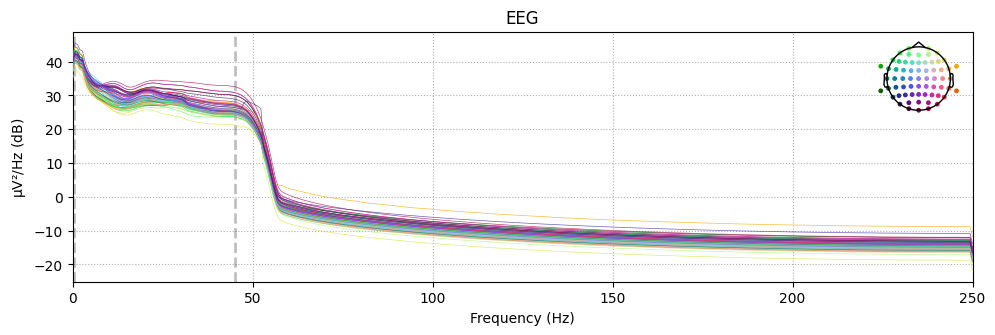

In [42]:
epochs_ransac.plot_psd()

## 4. Final visual inspection

Mark epochs that should be dropped, add more channels to interpolate etc.

In [43]:
# use indexing to plot fewer epochs (faster) e.g. [::7] shows only every 7th epoch
#epochs_[::10].plot(n_epochs=10,
#                   n_channels=32,
#                   scalings={'eeg': 20e-6})

In [44]:
# If you found more channels to interpolate, add them to the bads list

#bads.extend(['T7', 'CPz'])

# .append() for string e.g. 'F7'
# .extend() for list ['F7', 'F8']

In [45]:
# bads

In [46]:
# If you added more channels to the bads list, uncomment this line below (remove the # sign) 
# to interpolate the channels once again now with the extended list. 
# There is no need to uncomment this line if you did not add anything to the bads list.
#epochs_ransac = interpolate_bad_channels(epochs=epochs_autoreject, bads=bads)

In [47]:
# inspect which sensors were interpolated (if any)
print(epochs_ransac.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 2, interpolated: FT9, F3, T7, T8
 dig: 64 items (64 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2020-09-07 10:00:23 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 temp: 1_S_Day1_ICA_autoreject_ransac
>


## 5. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.


In [48]:
epochs_ransac.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Number of events,2134
Events,10: 17411: 68412: 16414: 4715: 20316: 26917: 18118: 4819: 16361: 18762: 14
Time range,-0.700 – 0.750 sec
Baseline,off


In [49]:
update_log(epochs_path, epochs_ransac, '')

,fid,highpass,lowpass,n_components,n_bad_epochs,total_drop_percentage,n_epochs_per_stimuli,stimuli,t_min,t_max,n_interpolated,average_ref_applied,baseline,notes,date_of_update,author,interpolated
0,1_S_Day1_ICA_autoreject_ransac,0.5,45.0,2.0,246,10.34,"10: 174, 11: 684, 12: 164, 14: 47, 15: 203, 16...","[10, 11, 12, 14, 15, 16, 17, 18, 19, 61, 62]",-0.7,0.75,4.0,True,NaN,,2022-05-03T16:19:39.088864,Teodora Vekony,"FT9,F3,T7,T8"


In [50]:
os.path.join(epochs_path, f'{epochs_ransac.info["temp"]}-epo.fif.gz')

'C:/Users/teodora.vekony/BML-MEMO LAB Dropbox/bml memo members/Teodora_Vekony/GitHub_Projects/eeg-workshop\\preprocessed\\epochs_asrt_new\\1_S_Day1_ICA_autoreject_ransac-epo.fif.gz'

In [51]:
epochs_ransac.save(os.path.join(epochs_path, f'{epochs_ransac.info["temp"]}-epo.fif.gz'), overwrite=True)

## 6. Remove incorrect responses, first trials, trills, repetitions

In [52]:
epochs_cleaned = epochs_ransac["triplet == 'low' | triplet == 'high' | triplet == 'practice'"]
epochs_cleaned = epochs_cleaned["answer == 'correct'"]

In [53]:
epochs_cleaned.metadata

,time_in_samples,stim,id,epoch,answer,arrow,triplet,triplet_type,sequence,stimuli,rewiring,trial_number_block,trial_number_task
3,244003,0,62,0.0,correct,left,practice,NaN,NaN,NaN,NaN,1,1
6,244762,0,62,0.0,correct,up,practice,NaN,NaN,NaN,NaN,2,2
9,245521,0,62,0.0,correct,down,practice,NaN,NaN,NaN,NaN,3,3
17,247056,0,62,0.0,correct,up,practice,NaN,NaN,NaN,NaN,5,5
23,248582,0,61,0.0,correct,left,practice,NaN,NaN,NaN,NaN,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,2976695,0,11,5.0,correct,down,high,pattern,A,pattern,high-low,77,2372
7714,2978213,0,15,5.0,correct,up,high,pattern,A,pattern,high-high,79,2374
7722,2979765,0,11,5.0,correct,right,high,pattern,A,pattern,high-low,81,2376
7725,2980524,0,14,5.0,correct,up,high,high-random,A,random,high-high,82,2377


In [54]:
epochs_cleaned.info["temp"] = epochs_ransac.info["temp"]+'_cleaned'
epochs_cleaned.info["temp"]

'1_S_Day1_ICA_autoreject_ransac_cleaned'

## 7. Save cleaned epochs

In [55]:
update_log(epochs_path, epochs_cleaned, '')

,fid,highpass,lowpass,n_components,n_bad_epochs,total_drop_percentage,n_epochs_per_stimuli,stimuli,t_min,t_max,n_interpolated,average_ref_applied,baseline,notes,date_of_update,author,interpolated
0,1_S_Day1_ICA_autoreject_ransac_cleaned,0.5,45.0,2.0,246,14.05,"10: 149, 11: 596, 12: 139, 14: 38, 15: 162, 16...","[10, 11, 12, 14, 15, 16, 61, 62]",-0.7,0.75,4.0,True,NaN,,2022-05-03T16:19:59.150357,Teodora Vekony,"FT9,F3,T7,T8"


In [56]:
os.path.join(epochs_path, f'{epochs_cleaned.info["temp"]}-epo.fif.gz')

'C:/Users/teodora.vekony/BML-MEMO LAB Dropbox/bml memo members/Teodora_Vekony/GitHub_Projects/eeg-workshop\\preprocessed\\epochs_asrt_new\\1_S_Day1_ICA_autoreject_ransac_cleaned-epo.fif.gz'

In [58]:
epochs_cleaned.save(os.path.join(epochs_path, f'{epochs_cleaned.info["temp"]}-epo.fif.gz'), overwrite=True)

Overwriting existing file.
